In [15]:
import os
import time
import math
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [16]:
VEHICLES_DIR = 'C:\\Users\\Admin\\Desktop\\40 projects\\data\\vehicles' 
NON_VEHICLES_DIR = 'C:\\Users\\Admin\\Desktop\\40 projects\\data\\non-vehicles'

In [17]:
vehicles_image_names = os.listdir(VEHICLES_DIR)
non_vehicles_image_names = os.listdir(NON_VEHICLES_DIR)

In [18]:
print('TOTAL NO. OF VEHICLE IMAGES:', len(vehicles_image_names))
print('TOTAL NO. OF NON-VEHICLE IMAGES:', len(non_vehicles_image_names))

TOTAL NO. OF VEHICLE IMAGES: 8792
TOTAL NO. OF NON-VEHICLE IMAGES: 8968


In [19]:
print(vehicles_image_names[:10])
print(non_vehicles_image_names[:10])

['1.png', '10.png', '1000.png', '1001.png', '1002.png', '1003.png', '1004.png', '1005.png', '1006.png', '1007.png']
['extra1.png', 'extra10.png', 'extra100.png', 'extra1000.png', 'extra1001.png', 'extra1002.png', 'extra1003.png', 'extra1004.png', 'extra1005.png', 'extra1006.png']


## Creatuing train test directory

In [20]:
BASE_DIR = '../tmp/'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')
VEHICLES_TRAIN_DIR = os.path.join(TRAIN_DIR, 'vehicles')
NON_VEHICLES_TRAIN_DIR = os.path.join(TRAIN_DIR, 'non-vehicles')
VEHICLES_TEST_DIR = os.path.join(TEST_DIR, 'vehicles')
NON_VEHICLES_TEST_DIR = os.path.join(TEST_DIR, 'non-vehicles')

In [21]:
TRAIN_SIZE = 0.8

In [22]:
train_vehicles, test_vehicles = train_test_split(
    vehicles_image_names, train_size=TRAIN_SIZE, shuffle=True, random_state=1
)

train_non_vehicles, test_non_vehicles = train_test_split(
    non_vehicles_image_names, train_size=TRAIN_SIZE, shuffle=True, random_state=1
)

In [23]:
print('TOTAL NO. OF TRAIN VEHICLE IMAGES:', len(train_vehicles))
print('TOTAL NO. OF TRAIN NON-VEHICLE IMAGES:', len(train_non_vehicles))

print('TOTAL NO. OF TEST VEHICLE IMAGES:', len(test_vehicles))
print('TOTAL NO. OF TEST NON-VEHICLE IMAGES:', len(test_non_vehicles))

TOTAL NO. OF TRAIN VEHICLE IMAGES: 7033
TOTAL NO. OF TRAIN NON-VEHICLE IMAGES: 7174
TOTAL NO. OF TEST VEHICLE IMAGES: 1759
TOTAL NO. OF TEST NON-VEHICLE IMAGES: 1794


In [26]:
def move_images(image_list, old_dir_path, new_dir_path):
    if not os.path.exists(new_dir_path):
        os.makedirs(new_dir_path)
    
    for file_name in image_list:
        shutil.copy(
            os.path.join(old_dir_path, file_name),
            os.path.join(new_dir_path, file_name)
        )
    print(f'{len(image_list)} IMAGES COPIED TO {new_dir_path}')

In [27]:
move_images(train_vehicles, VEHICLES_DIR, VEHICLES_TRAIN_DIR)
move_images(train_non_vehicles, NON_VEHICLES_DIR, NON_VEHICLES_TRAIN_DIR)

move_images(test_vehicles, VEHICLES_DIR, VEHICLES_TEST_DIR)
move_images(test_non_vehicles, NON_VEHICLES_DIR, NON_VEHICLES_TEST_DIR)

7033 IMAGES COPIED TO ../tmp/train\vehicles
7174 IMAGES COPIED TO ../tmp/train\non-vehicles
1759 IMAGES COPIED TO ../tmp/test\vehicles
1794 IMAGES COPIED TO ../tmp/test\non-vehicles


In [28]:
len(os.listdir(VEHICLES_TRAIN_DIR))

7033

## preprocessing

In [29]:
IMG_SIZE = 256

In [30]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    class_mode='binary'
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='binary'
)

Found 14207 images belonging to 2 classes.
Found 3553 images belonging to 2 classes.


## model

In [31]:
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D(2, 2),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 1)                 2

## model train

In [37]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5
)

model_path = 'vehicle_detection.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    model_path,
    save_best_only=True
)

In [39]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=2, #----can have more than 20 epoch
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/2
444/444 [==============================] - 1618s 4s/step - loss: 0.0427 - accuracy: 0.9867 - val_loss: 0.0682 - val_accuracy: 0.9800
Epoch 2/2
444/444 [==============================] - 1869s 4s/step - loss: 0.0250 - accuracy: 0.9923 - val_loss: 0.0376 - val_accuracy: 0.9873


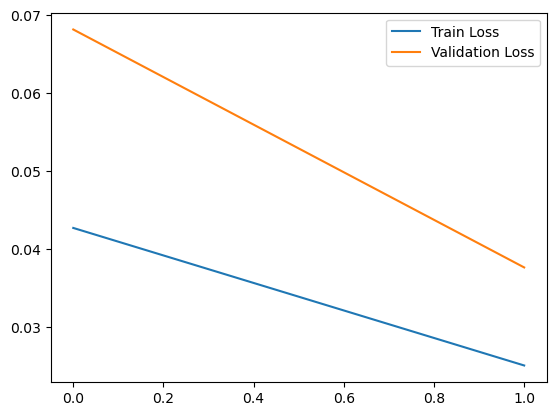

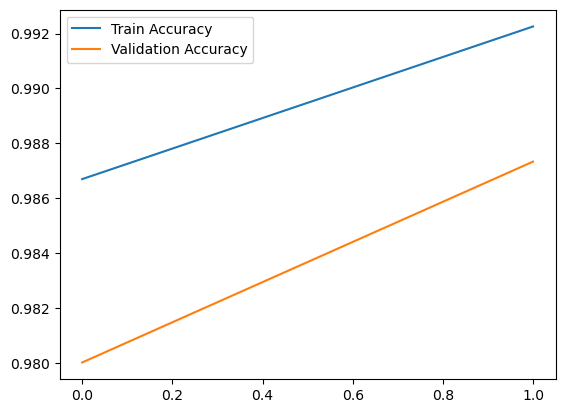

In [40]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


## Saving model

In [41]:
saved_model = tf.keras.models.load_model(model_path)
saved_model.evaluate(test_generator)

112/112 [==============================] - 140s 1s/step - loss: 0.0376 - accuracy: 0.9873


[0.037622012197971344, 0.987334668636322]